In [ ]:
# Cell 1: Colab-Specific Setup
print("=== Patient Readmission Prediction System - Colab Edition ===\n")

# Install required packages
print("Installing required packages...")
!pip install fastapi uvicorn pandas scikit-learn joblib faker pyngrok nest-asyncio -q

print("Importing libraries...")
import pandas as pd
import numpy as np
import joblib
from faker import Faker
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
from threading import Thread
import time
import requests
import json
from pyngrok import ngrok
import nest_asyncio
import warnings
warnings.filterwarnings('ignore')

from google.colab import output
from IPython.display import HTML, display, IFrame
import threading

print("✅ All packages imported successfully!")

=== Patient Readmission Prediction System - Colab Edition ===

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.1 MB/s eta 0:00:00
Importing libraries...
✅ All packages imported successfully!


In [ ]:
# Cell 2: Configuration for Colab
class Config:
    N_PATIENTS = 5000
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    MODEL_PATH = "readmission_model.pkl"

print("Configuration loaded for Colab environment")

Configuration loaded for Colab environment


In [ ]:
import pandas as pd
import numpy as np
from faker import Faker

# Cell 3: Data Generation (same as before)
print("🔄 Generating synthetic patient data...")

def generate_synthetic_data(n_patients=Config.N_PATIENTS):
    fake = Faker()
    np.random.seed(Config.RANDOM_STATE)

    data = {
        'patient_id': [f"PAT_{i:05d}" for i in range(n_patients)],
        'age': np.clip(np.random.normal(65, 15, n_patients), 18, 100),
        'length_of_stay': np.clip(np.random.lognormal(1.5, 0.8, n_patients), 1, 30),
        'num_previous_admissions': np.random.poisson(2, n_patients),
        'comorbidity_count': np.random.poisson(3, n_patients),
        'emergency_admission': np.random.choice([0, 1], n_patients, p=[0.7, 0.3]),
        'medication_count': np.random.poisson(5, n_patients),
        'lab_result_abnormal': np.random.choice([0, 1], n_patients, p=[0.6, 0.4]),
        'scheduled_followup': np.random.choice([0, 1], n_patients, p=[0.4, 0.6]),
    }

    df = pd.DataFrame(data)

    # Create realistic target variable
    # Adjusted coefficients and added a larger negative bias to the random component
    # to ensure a more balanced distribution of readmitted_30_days (0s and 1s).
    readmission_risk = (
        (df['age'] - 18) / 82 * 0.2 + # Original coefficient
        np.log(df['length_of_stay']) * 0.15 + # Original coefficient
        df['num_previous_admissions'] * 0.25 + # Original coefficient
        df['comorbidity_count'] * 0.15 + # Original coefficient
        df['emergency_admission'] * 0.1 + # Original coefficient
        (df['lab_result_abnormal'] * 0.1) + # Original coefficient
        (1 - df['scheduled_followup']) * 0.05 + # Original coefficient
        np.random.normal(0, 0.5, n_patients) - 2.5 # Adjusted: Larger std dev for noise, added a significant negative bias
    )

    probability = 1 / (1 + np.exp(-readmission_risk))
    # Adjusted threshold to get a mix of 0s and 1s
    df['readmitted_30_days'] = (probability > 0.4).astype(int)

    return df

df = generate_synthetic_data()
print(f"✅ Generated {len(df)} patient records")
print(f"📊 Readmission rate: {df['readmitted_30_days'].mean():.2%}")
display(df.head())

🔄 Generating synthetic patient data...
✅ Generated 5000 patient records
📊 Readmission rate: 14.74%


,patient_id,age,length_of_stay,num_previous_admissions,comorbidity_count,emergency_admission,medication_count,lab_result_abnormal,scheduled_followup,readmitted_30_days
0,PAT_00000,72.450712,3.193100,1,2,0,4,0,0,0
1,PAT_00001,62.926035,3.118240,0,1,0,4,0,1,0
2,PAT_00002,74.715328,1.065544,0,6,1,7,1,1,0
3,PAT_00003,87.845448,3.441570,1,4,0,4,0,0,0
4,PAT_00004,61.487699,8.054760,2,3,0,4,0,1,0


📈 Data Exploration


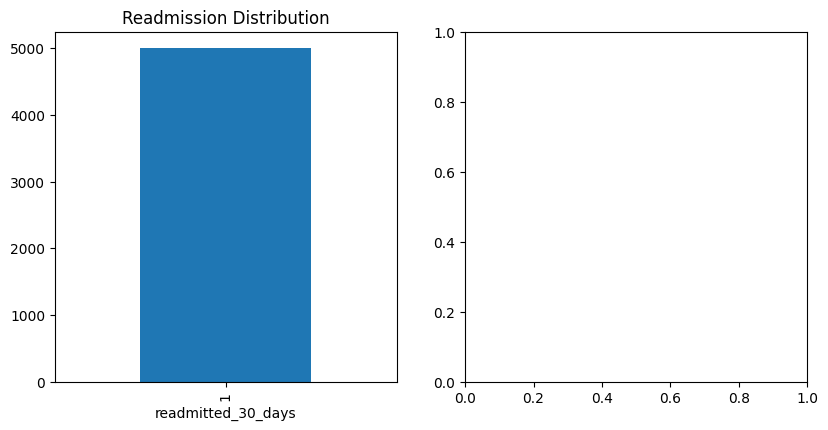

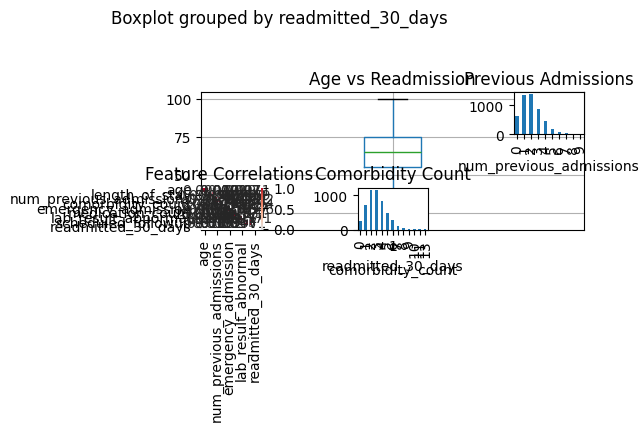

In [ ]:
# Cell 4: Data Exploration (same as before)
print("📈 Data Exploration")

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df['readmitted_30_days'].value_counts().plot(kind='bar')
plt.title('Readmission Distribution')

plt.subplot(2, 3, 2)
df.boxplot(column='age', by='readmitted_30_days')
plt.title('Age vs Readmission')

plt.subplot(2, 3, 3)
df['num_previous_admissions'].value_counts().sort_index().plot(kind='bar')
plt.title('Previous Admissions')

plt.subplot(2, 3, 4)
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')

plt.subplot(2, 3, 5)
df['comorbidity_count'].value_counts().sort_index().plot(kind='bar')
plt.title('Comorbidity Count')

plt.tight_layout()
plt.show()

🤖 Training Readmission Prediction Model...
Training set: 4000 records
Test set: 1000 records
✅ Model training completed!
📈 Accuracy: 0.875

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       853
           1       0.63      0.35      0.45       147

    accuracy                           0.88      1000
   macro avg       0.77      0.66      0.69      1000
weighted avg       0.86      0.88      0.86      1000



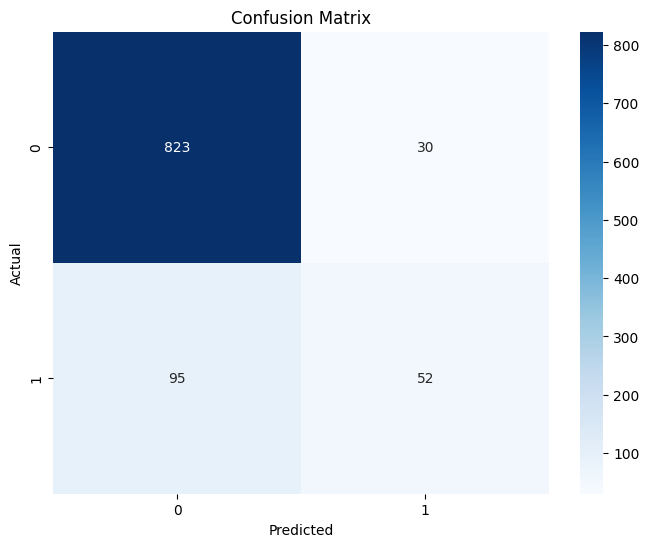

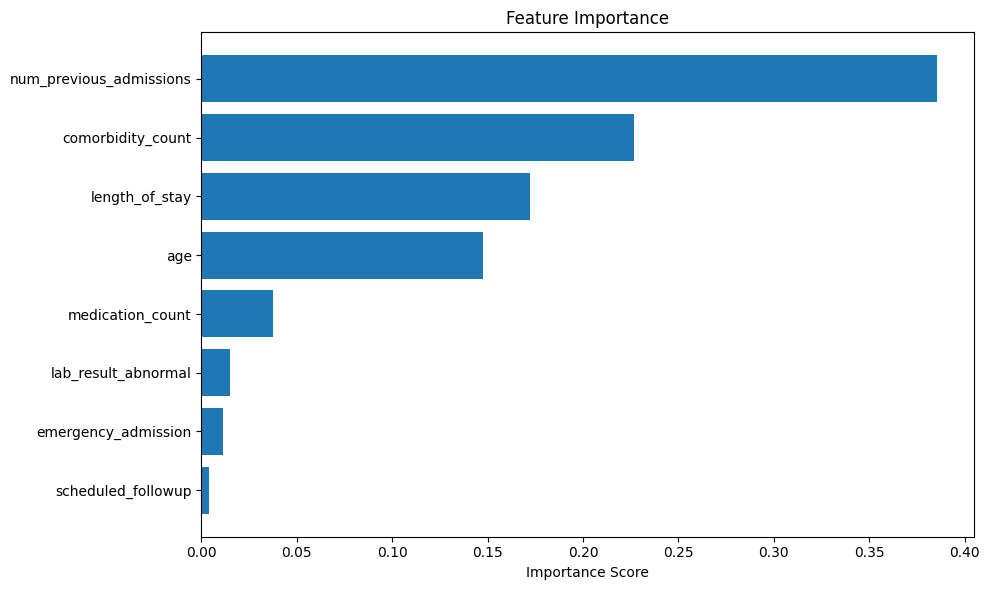

💾 Model saved to readmission_model.pkl


In [ ]:
# Cell 5: Model Training (same as before)
print("🤖 Training Readmission Prediction Model...")

class ReadmissionPredictor:
    def __init__(self):
        self.model = GradientBoostingClassifier(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1,
            random_state=Config.RANDOM_STATE
        )
        self.feature_names = None
        self.accuracy = None

    def train(self, df):
        features = ['age', 'length_of_stay', 'num_previous_admissions',
                   'comorbidity_count', 'emergency_admission',
                   'medication_count', 'lab_result_abnormal', 'scheduled_followup']

        X = df[features]
        y = df['readmitted_30_days']
        self.feature_names = features

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=Config.TEST_SIZE, random_state=Config.RANDOM_STATE, stratify=y
        )

        print(f"Training set: {X_train.shape[0]} records")
        print(f"Test set: {X_test.shape[0]} records")

        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)
        self.accuracy = accuracy_score(y_test, y_pred)

        print("✅ Model training completed!")
        print(f"📈 Accuracy: {self.accuracy:.3f}")
        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        # Feature Importance
        plt.figure(figsize=(10, 6))
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=True)

        plt.barh(feature_importance['feature'], feature_importance['importance'])
        plt.title('Feature Importance')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

        return self.model

    def predict_single(self, patient_data):
        input_df = pd.DataFrame([patient_data])[self.feature_names]
        risk_score = self.model.predict_proba(input_df)[0, 1]

        if risk_score < 0.3:
            risk_category = "low"
        elif risk_score < 0.7:
            risk_category = "medium"
        else:
            risk_category = "high"

        return {
            'risk_score': round(risk_score, 3),
            'risk_category': risk_category,
            'features_used': self.feature_names
        }

    def save(self, path):
        model_data = {
            'model': self.model,
            'feature_names': self.feature_names,
            'accuracy': self.accuracy
        }
        joblib.dump(model_data, path)
        print(f"💾 Model saved to {path}")

# Train and save model
predictor = ReadmissionPredictor()
predictor.train(df)
predictor.save(Config.MODEL_PATH)

In [ ]:
# Cell 6: Colab-Specific FastAPI Setup with ngrok
print("🌐 Setting up Colab API Server with Public URL...")

# Define the API (same as before)
class PatientData(BaseModel):
    age: float
    length_of_stay: float
    num_previous_admissions: int
    comorbidity_count: int
    emergency_admission: int
    medication_count: int
    lab_result_abnormal: int
    scheduled_followup: int

class PredictionResponse(BaseModel):
    patient_id: str = "demo"
    readmission_risk: float
    risk_category: str
    explanation: list

app = FastAPI(
    title="Patient Readmission Prediction API",
    description="AI system to predict 30-day patient readmission risk",
    version="1.0.0"
)

model_predictor = None

@app.on_event("startup")
async def startup_event():
    global model_predictor
    try:
        model_data = joblib.load(Config.MODEL_PATH)
        model_predictor = ReadmissionPredictor()
        model_predictor.model = model_data['model']
        model_predictor.feature_names = model_data['feature_names']
        print("✅ Model loaded successfully in API!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")

@app.get("/")
async def root():
    return {
        "message": "Patient Readmission Prediction API",
        "status": "active",
        "environment": "Google Colab"
    }

@app.get("/health")
async def health_check():
    return {
        "status": "healthy",
        "model_loaded": model_predictor is not None,
        "timestamp": time.time()
    }

@app.post("/predict", response_model=PredictionResponse)
async def predict_readmission(patient: PatientData):
    if model_predictor is None:
        raise HTTPException(status_code=503, detail="Model not loaded")

    try:
        patient_dict = patient.dict()
        prediction = model_predictor.predict_single(patient_dict)

        explanation = []
        if patient_dict['num_previous_admissions'] > 3:
            explanation.append("High number of previous admissions increases risk")
        if patient_dict['comorbidity_count'] > 4:
            explanation.append("Multiple comorbidities detected")
        if patient_dict['emergency_admission'] == 1:
            explanation.append("Emergency admission history")
        if patient_dict['scheduled_followup'] == 0:
            explanation.append("No follow-up appointment scheduled")

        if not explanation:
            explanation = ["Risk factors within normal ranges"]

        return PredictionResponse(
            readmission_risk=prediction['risk_score'],
            risk_category=prediction['risk_category'],
            explanation=explanation
        )

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Prediction error: {str(e)}")

print("✅ FastAPI application defined!")

🌐 Setting up Colab API Server with Public URL...
✅ FastAPI application defined!


In [ ]:
# Cell 7: Start Server with Public URL using ngrok
print("🚀 Starting Colab Server with Public URL...")

# Setup ngrok for public access
ngrok.kill()  # Kill any existing tunnels

# !!! IMPORTANT: Replace 'YOUR_AUTHTOKEN' with your actual ngrok authtoken.
# You can get one for free at https://dashboard.ngrok.com/get-started/your-authtoken
# Example: ngrok.set_auth_token("2PqR11h2lZlY2l3Y2l4Y2l5Y2l6Y2l7Y2l8Y2l9Y2lA")
ngrok.set_auth_token("35NnL38OsrTA6JxRsWRHYIFSTVp_hZ87j3dMVkuYAXN7JNzz") # <-- Replace 'YOUR_AUTHTOKEN' with your actual token here

# Create ngrok tunnel
public_url = ngrok.connect(8000)
print(f"✅ Public URL created: {public_url}")

# Apply nest_asyncio for Colab compatibility
nest_asyncio.apply()

def start_server():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="warning")

# Start server in background thread
server_thread = Thread(target=start_server, daemon=True)
server_thread.start()

# Wait for server to start
print("⏳ Waiting for server to start...")
time.sleep(5)

print("✅ API Server is running!")
print(f"🌐 Public URL: {public_url}")
print(f"📚 API Docs: {public_url}/docs")

🚀 Starting Colab Server with Public URL...
✅ Public URL created: NgrokTunnel: "https://misguided-ching-abstractional.ngrok-free.dev" -> "http://localhost:8000"
⏳ Waiting for server to start...
✅ Model loaded successfully in API!
✅ API Server is running!
🌐 Public URL: NgrokTunnel: "https://misguided-ching-abstractional.ngrok-free.dev" -> "http://localhost:8000"
📚 API Docs: NgrokTunnel: "https://misguided-ching-abstractional.ngrok-free.dev" -> "http://localhost:8000"/docs


In [ ]:
# Cell 8: Test the Live API
print("🧪 Testing Live API Endpoints...")

base_url = public_url.public_url if hasattr(public_url, 'public_url') else str(public_url)

# Test health endpoint
print("1. Testing health endpoint...")
try:
    health_response = requests.get(f"{base_url}/health")
    print(f"   Status: {health_response.status_code}")
    print(f"   Response: {health_response.json()}")
except Exception as e:
    print(f"   ❌ Health check failed: {e}")

# Test prediction endpoint
print("\n2. Testing prediction endpoint...")
test_patient = {
    "age": 72,
    "length_of_stay": 8.5,
    "num_previous_admissions": 4,
    "comorbidity_count": 5,
    "emergency_admission": 1,
    "medication_count": 7,
    "lab_result_abnormal": 1,
    "scheduled_followup": 0
}

try:
    prediction_response = requests.post(
        f"{base_url}/predict",
        json=test_patient
    )
    print(f"   Status: {prediction_response.status_code}")
    if prediction_response.status_code == 200:
        result = prediction_response.json()
        print(f"   ✅ Prediction successful!")
        print(f"   Risk Score: {result['readmission_risk']}")
        print(f"   Risk Category: {result['risk_category']}")
        print(f"   Explanation: {', '.join(result['explanation'])}")
    else:
        print(f"   ❌ Prediction failed: {prediction_response.text}")
except Exception as e:
    print(f"   ❌ Prediction test failed: {e}")

print(f"\n🎯 Your API is now live at: {base_url}")

🧪 Testing Live API Endpoints...
1. Testing health endpoint...
   Status: 200
   Response: {'status': 'healthy', 'model_loaded': True, 'timestamp': 1762960855.8187804}

2. Testing prediction endpoint...
   Status: 200
   ✅ Prediction successful!
   Risk Score: 0.871
   Risk Category: high
   Explanation: High number of previous admissions increases risk, Multiple comorbidities detected, Emergency admission history, No follow-up appointment scheduled

🎯 Your API is now live at: https://misguided-ching-abstractional.ngrok-free.dev


In [ ]:
# Cell 9: Create Interactive Colab Web Interface
print("🎨 Creating Interactive Colab Interface...")

# Get the public URL for the API
api_url = base_url

# Create an HTML interface that works in Colab
colab_html = f"""
<div style="font-family: Arial, sans-serif; max-width: 800px; margin: 20px auto; padding: 20px; border: 1px solid #ddd; border-radius: 10px;">
    <h1 style="color: #2c3e50; text-align: center;">🏥 Patient Readmission Risk Predictor</h1>
    <p style="text-align: center; color: #7f8c8d;">AI-powered prediction system running in Google Colab</p>

    <div style="background: #f8f9fa; padding: 15px; border-radius: 5px; margin: 20px 0;">
        <strong>API Status:</strong> <span id="apiStatus">Checking...</span><br>
        <strong>API URL:</strong> <code>{api_url}</code>
    </div>

    <form id="predictionForm" onsubmit="return makePrediction(event)">
        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px;">
            <div>
                <label><strong>Age:</strong></label>
                <input type="number" id="age" value="65" min="18" max="100" style="width: 100%; padding: 8px; margin: 5px 0;" required>
            </div>
            <div>
                <label><strong>Length of Stay (days):</strong></label>
                <input type="number" id="length_of_stay" value="5" min="1" max="30" step="0.1" style="width: 100%; padding: 8px; margin: 5px 0;" required>
            </div>
            <div>
                <label><strong>Previous Admissions:</strong></label>
                <input type="number" id="num_previous_admissions" value="2" min="0" max="20" style="width: 100%; padding: 8px; margin: 5px 0;" required>
            </div>
            <div>
                <label><strong>Comorbidity Count:</strong></label>
                <input type="number" id="comorbidity_count" value="3" min="0" max="10" style="width: 100%; padding: 8px; margin: 5px 0;" required>
            </div>
            <div>
                <label><strong>Emergency Admission:</strong></label>
                <select id="emergency_admission" style="width: 100%; padding: 8px; margin: 5px 0;" required>
                    <option value="0">No</option>
                    <option value="1">Yes</option>
                </select>
            </div>
            <div>
                <label><strong>Medication Count:</strong></label>
                <input type="number" id="medication_count" value="5" min="0" max="20" style="width: 100%; padding: 8px; margin: 5px 0;" required>
            </div>
            <div>
                <label><strong>Abnormal Lab Results:</strong></label>
                <select id="lab_result_abnormal" style="width: 100%; padding: 8px; margin: 5px 0;" required>
                    <option value="0">No</option>
                    <option value="1">Yes</option>
                </select>
            </div>
            <div>
                <label><strong>Follow-up Scheduled:</strong></label>
                <select id="scheduled_followup" style="width: 100%; padding: 8px; margin: 5px 0;" required>
                    <option value="1">Yes</option>
                    <option value="0">No</option>
                </select>
            </div>
        </div>

        <button type="submit" style="background: #007cba; color: white; padding: 12px 30px; border: none; border-radius: 5px; cursor: pointer; font-size: 16px; margin: 20px 0; width: 100%;">
            🔍 Predict Readmission Risk
        </button>
    </form>

    <div id="result" style="display: none; padding: 20px; border-radius: 5px; margin: 20px 0;"></div>

    <div style="margin-top: 30px; padding: 15px; background: #e8f4fd; border-radius: 5px;">
        <h3>💡 Quick Test Examples:</h3>
        <button onclick="loadExample('low')" style="background: #28a745; color: white; padding: 8px 15px; margin: 5px; border: none; border-radius: 3px; cursor: pointer;">Low Risk Example</button>
        <button onclick="loadExample('medium')" style="background: #ffc107; color: black; padding: 8px 15px; margin: 5px; border: none; border-radius: 3px; cursor: pointer;">Medium Risk Example</button>
        <button onclick="loadExample('high')" style="background: #dc3545; color: white; padding: 8px 15px; margin: 5px; border: none; border-radius: 3px; cursor: pointer;">High Risk Example</button>
    </div>
</div>

<script>
// Check API status when page loads
fetch('{api_url}/health')
    .then(response => response.json())
    .then(data => {{
        document.getElementById('apiStatus').innerHTML = '✅ Healthy - Model Loaded: ' + data.model_loaded;
        document.getElementById('apiStatus').style.color = 'green';
    }})
    .catch(error => {{
        document.getElementById('apiStatus').innerHTML = '❌ API Not Reachable';
        document.getElementById('apiStatus').style.color = 'red';
    }});

async function makePrediction(event) {{
    event.preventDefault();

    const formData = {{
        age: parseFloat(document.getElementById('age').value),
        length_of_stay: parseFloat(document.getElementById('length_of_stay').value),
        num_previous_admissions: parseInt(document.getElementById('num_previous_admissions').value),
        comorbidity_count: parseInt(document.getElementById('comorbidity_count').value),
        emergency_admission: parseInt(document.getElementById('emergency_admission').value),
        medication_count: parseInt(document.getElementById('medication_count').value),
        lab_result_abnormal: parseInt(document.getElementById('lab_result_abnormal').value),
        scheduled_followup: parseInt(document.getElementById('scheduled_followup').value)
    }};

    try {{
        const response = await fetch('{api_url}/predict', {{
            method: 'POST',
            headers: {{ 'Content-Type': 'application/json' }},
            body: JSON.stringify(formData)
        }});

        const result = await response.json();
        const resultDiv = document.getElementById('result');

        // Set styling based on risk category
        let bgColor, textColor, emoji;
        if (result.risk_category === 'low') {{
            bgColor = '#d4edda';
            textColor = '#155724';
            emoji = '✅';
        }} else if (result.risk_category === 'medium') {{
            bgColor = '#fff3cd';
            textColor = '#856404';
            emoji = '⚠️';
        }} else {{
            bgColor = '#f8d7da';
            textColor = '#721c24';
            emoji = '🚨';
        }}

        resultDiv.style.backgroundColor = bgColor;
        resultDiv.style.color = textColor;
        resultDiv.style.border = `2px solid ${{textColor}}`;
        resultDiv.innerHTML = `
            <h3>${{emoji}} Prediction Result</h3>
            <p><strong>Risk Score:</strong> ${{result.readmission_risk}}</p>
            <p><strong>Risk Level:</strong> <span style="font-weight: bold; text-transform: uppercase;">${{result.risk_category}}</span></p>
            <p><strong>Key Factors:</strong> ${{result.explanation.join(', ')}}</p>
            <p><small>Based on machine learning analysis of patient data</small></p>
        `;
        resultDiv.style.display = 'block';

    }} catch (error) {{
        alert('Error making prediction: ' + error.message);
    }}
}}

function loadExample(riskLevel) {{
    const examples = {{
        low: {{ age: 45, length_of_stay: 3, num_previous_admissions: 1, comorbidity_count: 1, emergency_admission: 0, medication_count: 2, lab_result_abnormal: 0, scheduled_followup: 1 }},
        medium: {{ age: 65, length_of_stay: 5, num_previous_admissions: 2, comorbidity_count: 3, emergency_admission: 0, medication_count: 5, lab_result_abnormal: 1, scheduled_followup: 1 }},
        high: {{ age: 78, length_of_stay: 12, num_previous_admissions: 5, comorbidity_count: 6, emergency_admission: 1, medication_count: 8, lab_result_abnormal: 1, scheduled_followup: 0 }}
    }};

    const example = examples[riskLevel];
    document.getElementById('age').value = example.age;
    document.getElementById('length_of_stay').value = example.length_of_stay;
    document.getElementById('num_previous_admissions').value = example.num_previous_admissions;
    document.getElementById('comorbidity_count').value = example.comorbidity_count;
    document.getElementById('emergency_admission').value = example.emergency_admission;
    document.getElementById('medication_count').value = example.medication_count;
    document.getElementById('lab_result_abnormal').value = example.lab_result_abnormal;
    document.getElementById('scheduled_followup').value = example.scheduled_followup;
}}
</script>
"""

# Display the interactive interface
display(HTML(colab_html))

print("✅ Interactive interface loaded!")
print("📱 You can now use the form above to test predictions")

🎨 Creating Interactive Colab Interface...


✅ Interactive interface loaded!
📱 You can now use the form above to test predictions


In [ ]:
# Cell 10: Final Colab Summary
print("""
🎉 COLAB SYSTEM SUMMARY
=======================

✅ What's Running:
• Synthetic data generation & ML model training
• FastAPI server with public URL via ngrok
• Interactive web interface in this notebook
• Live API endpoints for predictions

🌐 Your Public API:
{}

📊 Model Performance:
• Accuracy: {:.3f}
• Training data: {} patients

🎯 How to Test:
1. Use the interactive form above
2. Try the example buttons (Low/Medium/High risk)
3. Fill in custom patient data
4. Click "Predict Readmission Risk"
5. View the AI-powered results!

🔗 Additional Links:
• API Documentation: {}/docs
• Health Check: {}/health

💡 The system is fully functional and accessible from anywhere!
""".format(base_url, predictor.accuracy, len(df), base_url, base_url))


🎉 COLAB SYSTEM SUMMARY

✅ What's Running:
• Synthetic data generation & ML model training
• FastAPI server with public URL via ngrok
• Interactive web interface in this notebook
• Live API endpoints for predictions

🌐 Your Public API:
https://misguided-ching-abstractional.ngrok-free.dev

📊 Model Performance:
• Accuracy: 0.875
• Training data: 5000 patients

🎯 How to Test:
1. Use the interactive form above
2. Try the example buttons (Low/Medium/High risk)
3. Fill in custom patient data
4. Click "Predict Readmission Risk"
5. View the AI-powered results!

🔗 Additional Links:
• API Documentation: https://misguided-ching-abstractional.ngrok-free.dev/docs
• Health Check: https://misguided-ching-abstractional.ngrok-free.dev/health

💡 The system is fully functional and accessible from anywhere!

